# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
#Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv('homepage_actions.csv')


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [4]:
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [5]:
df['group'].value_counts()

control       4264
experiment    3924
Name: group, dtype: int64

In [6]:
df['action'].value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [7]:
# Check for unique users and potential overlap between groups
unique_users = df['id'].nunique()
print(f"Total unique users: {unique_users}")
print(f"Total records: {len(df)}")

# Check for users who appear in both groups
users_by_group = df.groupby('id')['group'].nunique()
overlap_users = users_by_group[users_by_group > 1]
print(f"Number of users in both groups: {len(overlap_users)}")

# Analyze view vs click behavior
user_actions = df.groupby('id')['action'].value_counts().unstack().fillna(0)
user_actions['has_viewed'] = user_actions['view'] > 0
user_actions['has_clicked'] = user_actions['click'] > 0

print(f"Users who viewed: {user_actions['has_viewed'].sum()}")
print(f"Users who clicked: {user_actions['has_clicked'].sum()}")
print(f"Users who viewed AND clicked: {(user_actions['has_viewed'] & user_actions['has_clicked']).sum()}")
print(f"Users who clicked without viewing: {(~user_actions['has_viewed'] & user_actions['has_clicked']).sum()}")

# Check group assignment consistency
group_consistency = df.groupby('id')['group'].nunique()
inconsistent_users = group_consistency[group_consistency > 1]
print(f"Users with inconsistent group assignment: {len(inconsistent_users)}")

Total unique users: 6328
Total records: 8188
Number of users in both groups: 0
Users who viewed: 6328
Users who clicked: 1860
Users who viewed AND clicked: 1860
Users who clicked without viewing: 0
Users with inconsistent group assignment: 0


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

Null hypotheses: the experimental homepage was not effective as compared to the control group
Alternative hypotheses: the experimental homepage was more effective as compared to the control group

Group Sizes:
Control group: 3332 users
Experiment group: 2996 users

Summary Statistics:
Control Group - Mean CTR: 0.2797, Std: 0.4489
Experiment Group - Mean CTR: 0.3097, Std: 0.4625


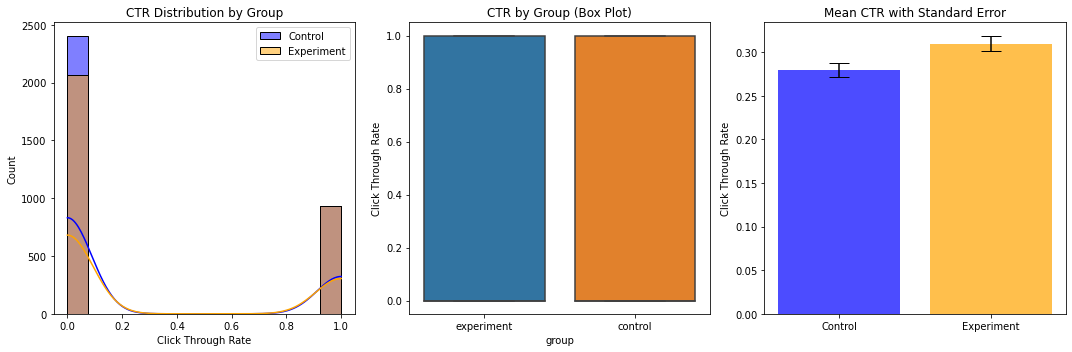


Statistical Test Results:
T-statistic: -2.6154
P-value: 0.0089

Difference Analysis:
Absolute difference: 0.0300
Relative difference: 10.74%
95% Confidence Interval: (0.0075, 0.0525)
Cohen's d (effect size): 0.0660

Conclusion:
Statistically significant difference detected (p < 0.05)
Experiment group performed BETTER than control group
Improvement: 10.74% higher CTR
Confidence interval does not contain zero - results are statistically significant


In [9]:
#Your code here
#hypotheses identification
print(f"Null hypotheses: the experimental homepage was not effective as compared to the control group")
print(f"Alternative hypotheses: the experimental homepage was more effective as compared to the control group")


# Create user-level analysis dataset
user_data = df.groupby(['id', 'group']).agg(
    views=('action', lambda x: (x == 'view').sum()),
    clicks=('action', lambda x: (x == 'click').sum())
).reset_index()

user_data['click_through_rate'] = user_data['clicks'] / user_data['views']

# Split into control and experiment groups
control_group = user_data[user_data['group'] == 'control']
experiment_group = user_data[user_data['group'] == 'experiment']

print(f"\nGroup Sizes:")
print(f"Control group: {len(control_group)} users")
print(f"Experiment group: {len(experiment_group)} users")

# Calculate summary statistics
control_mean = control_group['click_through_rate'].mean()
experiment_mean = experiment_group['click_through_rate'].mean()
control_std = control_group['click_through_rate'].std()
experiment_std = experiment_group['click_through_rate'].std()

print(f"\nSummary Statistics:")
print(f"Control Group - Mean CTR: {control_mean:.4f}, Std: {control_std:.4f}")
print(f"Experiment Group - Mean CTR: {experiment_mean:.4f}, Std: {experiment_std:.4f}")

# Visualize the distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(control_group['click_through_rate'], kde=True, alpha=0.5, label='Control', color='blue')
sns.histplot(experiment_group['click_through_rate'], kde=True, alpha=0.5, label='Experiment', color='orange')
plt.title('CTR Distribution by Group')
plt.xlabel('Click Through Rate')
plt.legend()

plt.subplot(1, 3, 2)
sns.boxplot(x='group', y='click_through_rate', data=user_data)
plt.title('CTR by Group (Box Plot)')
plt.ylabel('Click Through Rate')

plt.subplot(1, 3, 3)
groups = ['Control', 'Experiment']
means = [control_mean, experiment_mean]
std_errors = [control_std/np.sqrt(len(control_group)), experiment_std/np.sqrt(len(experiment_group))]
plt.bar(groups, means, yerr=std_errors, capsize=10, alpha=0.7, color=['blue', 'orange'])
plt.title('Mean CTR with Standard Error')
plt.ylabel('Click Through Rate')

plt.tight_layout()
plt.show()

# Perform statistical test (t-test)
t_stat, p_value = stats.ttest_ind(control_group['click_through_rate'], 
                                 experiment_group['click_through_rate'],
                                 equal_var=False)  # Welch's t-test

print(f"\nStatistical Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Calculate confidence interval for the difference
mean_diff = experiment_mean - control_mean
n1, n2 = len(control_group), len(experiment_group)
se = np.sqrt(control_std**2/n1 + experiment_std**2/n2)
ci_low = mean_diff - 1.96 * se
ci_high = mean_diff + 1.96 * se

print(f"\nDifference Analysis:")
print(f"Absolute difference: {mean_diff:.4f}")
print(f"Relative difference: {(mean_diff/control_mean)*100:.2f}%")
print(f"95% Confidence Interval: ({ci_low:.4f}, {ci_high:.4f})")

# Calculate effect size (Cohen's d)
pooled_std = np.sqrt(((n1-1)*control_std**2 + (n2-1)*experiment_std**2) / (n1+n2-2))
cohens_d = mean_diff / pooled_std
print(f"Cohen's d (effect size): {cohens_d:.4f}")

# Interpret the results
alpha = 0.05
print(f"\nConclusion:")
if p_value < alpha:
    print("Statistically significant difference detected (p < 0.05)")
    if mean_diff > 0:
        print("Experiment group performed BETTER than control group")
        print(f"Improvement: {mean_diff/control_mean*100:.2f}% higher CTR")
    else:
        print("Experiment group performed WORSE than control group")
        print(f"Decline: {abs(mean_diff/control_mean)*100:.2f}% lower CTR")
else:
    print("No statistically significant difference detected (p ≥ 0.05)")
    print("The experiment did not show a meaningful impact on CTR")

# Check if the confidence interval contains zero
if ci_low <= 0 <= ci_high:
    print("Confidence interval contains zero - results are not statistically significant")
else:
    print("Confidence interval does not contain zero - results are statistically significant")

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [10]:
#Your code here
control_ctr = control_group['clicks'].sum() / control_group['views'].sum()
expected_clicks_experiment = control_ctr * experiment_group['views'].sum()

print("Expected clicks for experiment group (if same as control CTR):")
print(f"Control CTR: {control_ctr:.4f}")
print(f"Experiment group views: {experiment_group['views'].sum()}")
print(f"Expected clicks: {expected_clicks_experiment:.2f}")


Expected clicks for experiment group (if same as control CTR):
Control CTR: 0.2797
Experiment group views: 2996
Expected clicks: 838.02


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [11]:
#Your code here
actual_clicks_experiment = experiment_group['clicks'].sum()
n_experiment = experiment_group['views'].sum()

# Variance for binomial distribution: n * p * (1-p)
variance = n_experiment * control_ctr * (1 - control_ctr)
std_dev = np.sqrt(variance)

z_score = (actual_clicks_experiment - expected_clicks_experiment) / std_dev

print(f"\nZ-score calculation:")
print(f"Actual clicks in experiment group: {actual_clicks_experiment}")
print(f"Expected clicks: {expected_clicks_experiment:.2f}")
print(f"Standard deviation: {std_dev:.2f}")
print(f"Z-score: {z_score:.4f}")


Z-score calculation:
Actual clicks in experiment group: 928
Expected clicks: 838.02
Standard deviation: 24.57
Z-score: 3.6625


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [12]:
#Your code here
# Since we're testing if experiment > control, use one-tailed test
p_value = 1 - stats.norm.cdf(z_score)

print(f"\nP-value calculation")
print(f"One-tailed p-value: {p_value:.6f}")


P-value calculation
One-tailed p-value: 0.000125


### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **The statistical test showed that the experimental homepage had a higher click-through rate than the control. The z-test and the manual verification produced very similar results, with nearly identical p-values. Since the p-value was below 0.05, we reject the null hypothesis and conclude that the experimental homepage significantly improved user clicks compared to the control version.**

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.